In [1]:
cd ../src

/home/richard/Desktop/software/epicluster-results_upload/epicluster-results/src


In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import copy
import scipy.stats
import branchpro
import epicluster as ec

In [3]:
random.seed(123)
np.random.seed(123)

In [4]:
branchpro7_means = []
branchpro28_means = []
epifilter_means = []
nonp_means = []

for i in range(10):

    # serial interval
    w = scipy.stats.gamma(2.707, scale=1/0.177)
    w = w.pdf(np.arange(50))
    w = w / sum(w)


    # data
    data = pd.read_csv("../data/synthetic/ebola_seed{}.csv".format(i))
    Rt_series = np.asarray(data['Rt'])
    cases = np.asarray(data['cases'])

    past_cases = np.ones(len(w)) * 5
    inf_cases = np.concatenate([past_cases, cases])



    # run branchpro
    a = 1
    b = 5

    inc_data = pd.DataFrame(
        {
            'Time': np.arange(len(inf_cases)),
            'Incidence Number': inf_cases
        }
    )

    inference = branchpro.BranchProPosterior(
        inc_data=inc_data,
        daily_serial_interval=w,
        alpha=a,
        beta=1/b)

    inference.run_inference(tau=7)
    intervals7 = inference.get_intervals(central_prob=.9)

    inference.run_inference(tau=28)
    intervals28 = inference.get_intervals(central_prob=.9)


    # run change point
    p = ec.PoissonModel(copy.deepcopy(inf_cases), w, prior_expected_clusters=1.5)
    mcmc = ec.MCMCSampler(p, 2)
    phi_chain, z_chain, counts = mcmc.run_mcmc(Rhat_thresh=1.05, progress=True)


    Rs = []
    num_mcmc = len(z_chain)
    for phi, z in zip(phi_chain[num_mcmc//4:], z_chain[num_mcmc//4:]):
        Rs.append([phi[zi] for zi in z])

    # load epifilter
    epi_results = pd.read_csv('../data/synthetic/results/ebola/ebola_{}.csv'.format(i))


    # save results
    branchpro7_means.append(intervals7['Mean'][len(w):])
    branchpro28_means.append(intervals28['Mean'][len(w):])
    epifilter_means.append(epi_results['R_smooth'][1:])
    nonp_means.append(np.mean(Rs, axis=0))
    

Iter=50, Rhat=107.32163416396473
Iter=100, Rhat=50.567462078634904
Iter=150, Rhat=31.54989002915927
Iter=200, Rhat=28.885637349255198
Iter=250, Rhat=21.095516801690447
Iter=300, Rhat=15.397330490640062
Iter=350, Rhat=13.433656877632432
Iter=400, Rhat=9.672393635335098
Iter=450, Rhat=7.851452289905685
Iter=500, Rhat=6.676776677086263
Iter=550, Rhat=6.096878868394044
Iter=600, Rhat=4.773978051165945
Iter=650, Rhat=3.697684150868695
Iter=700, Rhat=3.2813820345868416
Iter=750, Rhat=3.15577057402639
Iter=800, Rhat=2.907471519247579
Iter=850, Rhat=2.470862778783851
Iter=900, Rhat=2.045621053564986
Iter=950, Rhat=1.6582914758829308
Iter=1000, Rhat=1.452060508609871
Iter=1050, Rhat=1.3368103200888084
Iter=1100, Rhat=1.2641551301393434
Iter=1150, Rhat=1.2095782701648456
Iter=1200, Rhat=1.1585869111784268
Iter=1250, Rhat=1.1082772894500472
Iter=1300, Rhat=1.061043940968498
Iter=1350, Rhat=1.0106953122530633
Converged 1350 1.0106953122530633
Iter=50, Rhat=103.56736524668108
Iter=100, Rhat=70.0055

Iter=50, Rhat=97.13077744907434
Iter=100, Rhat=70.884263507424
Iter=150, Rhat=40.01420674992803
Iter=200, Rhat=26.374251217159077
Iter=250, Rhat=17.613026853393055
Iter=300, Rhat=14.722633800022205
Iter=350, Rhat=11.804560175508696
Iter=400, Rhat=9.148767011062587
Iter=450, Rhat=7.823732077525925
Iter=500, Rhat=6.160709341190896
Iter=550, Rhat=4.8961279853993895
Iter=600, Rhat=3.910470016432448
Iter=650, Rhat=3.2705271518359935
Iter=700, Rhat=3.1428757543640113
Iter=750, Rhat=2.848596954146644
Iter=800, Rhat=2.2908026356188977
Iter=850, Rhat=1.775326287666601
Iter=900, Rhat=1.5097439961957326
Iter=950, Rhat=1.3480811202520573
Iter=1000, Rhat=1.2376840270052658
Iter=1050, Rhat=1.1625667128853472
Iter=1100, Rhat=1.1015919481162284
Iter=1150, Rhat=1.0579422339318574
Iter=1200, Rhat=1.0225147286351906
Converged 1200 1.0225147286351906


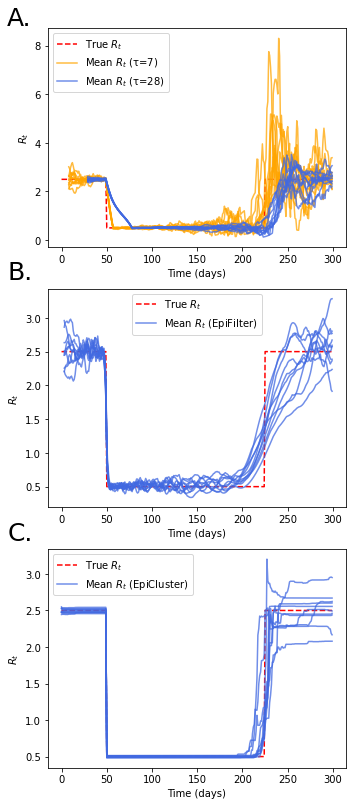

In [12]:
fig = plt.figure(figsize=(5,11))


ax = fig.add_subplot(3, 1, 1)

x = np.arange(len(cases))
ax.plot(x, Rt_series, color='red', label='True $R_t$', ls='--')

for i, mean in enumerate(branchpro7_means):
    x = np.arange(8, len(cases))
    ax.plot(x, mean, color='orange', alpha=0.75, label='Mean $R_t$ (τ=7)' if i==0 else None)
    
for i, mean in enumerate(branchpro28_means):
    x = np.arange(29, len(cases))
    ax.plot(x, mean, color='royalblue', alpha=0.75, label='Mean $R_t$ (τ=28)' if i==0 else None)
ax.legend()
ax.set_xlabel('Time (days)')
ax.set_ylabel('$R_t$')


ax = fig.add_subplot(3, 1, 2)
x = np.arange(len(cases))
ax.plot(x, Rt_series, color='red', label='True $R_t$', ls='--')

for i, mean in enumerate(epifilter_means):
    x = epi_results['day'][1:]
    ax.plot(x, mean, color='royalblue', alpha=0.75, label='Mean $R_t$ (EpiFilter)' if i==0 else None)
ax.legend()
ax.set_xlabel('Time (days)')
ax.set_ylabel('$R_t$')


ax = fig.add_subplot(3, 1, 3)
x = np.arange(len(cases))
ax.plot(x, Rt_series, color='red', label='True $R_t$', ls='--')

for i, mean in enumerate(nonp_means):
    x = np.arange(len(cases))
    ax.plot(x, mean, color='royalblue', alpha=0.75, label='Mean $R_t$ (EpiCluster)' if i==0 else None)

ax.legend()
ax.set_xlabel('Time (days)')
ax.set_ylabel('$R_t$')



fig.set_tight_layout(True)

plt.subplots_adjust(left=0.2)
fig.text(.03, .99, 'A.', fontsize=25)
fig.text(.03, .67, 'B.', fontsize=25)
fig.text(.03, .34, 'C.', fontsize=25)

plt.savefig('../notebooks/FigureS3.pdf')
plt.show()
